In [2]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict


def get_default_args():
    args = OrderedDict()
    args['dataset'] = 'cifar10'
    args['data_augmentation'] = 'True'
    args['seed'] = 1
    args['sorting_file'] = 'none'
    args['remove_n'] = 15000
    args['keep_lowest_n'] = 0
    args['burn_in_epochs'] = 200
    args['mode'] = 'online'
    args['remove_strategy'] = 'unforgettable'
    return args

def get_fname_from_args(args):
    fname = '__'.join("{}_{}".format(arg, args[arg]) for arg in args)
    return fname

def get_stats(data_dir, **kwargs):
    args = get_default_args()
    for key in kwargs:
        args[key] = kwargs[key]
    saved_fname = get_fname_from_args(args)
    fname = os.path.join(data_dir, saved_fname) + '__stats_dict.pkl'
    with open(fname, 'rb') as fin:
        data_stats = pickle.load(fin)
    return data_stats

50000


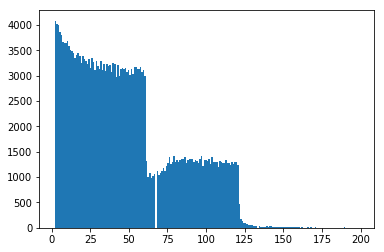

In [19]:
def draw_events_distribution():
    epochs = 200
    data_stats = get_stats('./online_results', burn_in_epochs=epochs)

    forgetting_happens = []
    # iterate on every example
    for example_id, example_stats in data_stats.items():
        # skip 'train' and 'test' keys of diag_stats
        if not isinstance(example_id, str):
            # forgetting event is a transition in accuracy from 1 to 0
            presentation_acc = np.array(example_stats[1][:epochs])
            transitions = presentation_acc[1:] - presentation_acc[:-1]
            forgetting_epoch_idx = np.where(transitions == -1)[0] + 2
            forgetting_happens.append(forgetting_epoch_idx)            
    print(len(forgetting_happens))
    result = np.concatenate(forgetting_happens)
    plt.hist(result, bins=epochs)
    plt.show()

draw_events_distribution()

193
199
198
200
200
199
196
200
197
197
198
198
199
194
199
198
198
175
183
181
196
164
200
199
195
197
197
170
196
171
197
198
200
196
199
171
198
196
172
127
198
199
175
200
200
198
200
169
193
197
186
173
196
189
199
197
180
196
195
188
200
199
200
197
199
199
191
182
200
198
174
191
197
197
129
196
198
193
181
198
179
155
199
176
171
185
196
199
197
163
163
195
171
199
198
200
199
194
194
190
189
197
185
196
200
200
199
188
198
199
188
178
200
186
198
199
194
200
199
199
199
190
199
189
200
198
198
193
172
200
171
182
199
199
200
196
200
196
199
200
176
168
151
200
191
199
182
198
197
199
194
151
200
199
186
199
156
182
197
169
200
199
184
199
199
199
187
199
186
198
187
197
200
193
195
199
199
199
187
162
197
196
199
197
199
177
199
199
200
130
192
172
200
195
195
196
197
187
198
198
199
200
200
195
200
199
199
198
197
199
199
197
198
200
195
153
199
195
200
200
199
200
200
178
200
199
199
193
200
184
184
197
160
198
193
198
197
200
200
199
199
172
180
198
200
195
195
199
155
185


200
167
198
179
196
196
200
195
200
194
196
196
200
196
197
200
172
183
149
194
197
197
199
199
196
194
200
199
198
192
199
197
195
199
200
190
129
200
194
194
195
194
197
157
179
200
187
199
200
189
181
199
198
199
197
200
185
199
199
173
200
198
193
195
200
193
183
179
191
194
200
174
187
186
199
198
200
198
200
199
199
185
197
200
200
190
162
188
199
200
200
192
200
182
199
199
200
199
189
186
199
198
186
176
190
199
192
200
196
199
164
195
200
195
199
183
172
199
154
189
181
193
199
199
199
197
199
182
194
200
198
194
200
198
197
200
170
176
178
200
115
192
195
200
198
170
194
200
166
193
192
199
199
196
200
200
199
197
198
172
200
161
199
200
172
200
200
194
199
200
193
199
199
191
198
196
196
194
199
192
197
195
184
195
197
198
200
197
199
198
198
199
200
180
200
173
167
198
200
177
158
200
198
199
188
199
200
200
200
200
200
198
200
195
195
192
199
193
199
177
189
191
193
196
200
200
198
193
198
200
200
199
194
166
183
200
184
189
197
189
192
197
192
200
199
178
187
198
199
200


199
199
166
182
198
195
193
192
177
199
197
199
184
192
198
192
167
198
194
199
190
199
189
140
199
181
187
199
198
197
172
188
152
196
193
198
200
195
199
193
187
200
197
193
200
180
199
184
197
196
173
200
166
199
192
199
190
200
176
200
174
196
200
200
195
200
200
188
189
196
200
157
192
199
199
199
197
194
191
164
182
192
158
199
198
200
199
187
171
197
196
199
199
200
192
192
197
199
191
142
200
196
178
199
196
200
199
198
138
192
197
200
159
200
200
200
197
200
200
199
200
195
200
188
175
198
197
198
198
199
186
192
168
180
199
193
200
144
198
200
199
199
178
198
193
163
199
200
162
199
197
166
199
150
192
186
195
185
198
200
200
187
199
200
200
191
198
193
185
156
198
200
200
195
196
190
196
148
200
199
187
196
194
200
200
184
194
190
197
200
175
192
193
200
200
191
174
198
187
199
200
191
199
193
200
199
197
171
196
199
170
197
196
182
200
193
198
183
196
200
125
187
196
198
142
200
180
197
172
200
198
198
195
200
199
196
200
199
199
199
186
185
156
198
199
180
194
199
117
200


188
199
200
197
160
200
184
172
171
176
199
165
189
186
190
176
199
200
149
198
161
187
193
197
198
198
199
149
186
176
199
186
199
189
194
194
199
198
200
123
199
198
183
199
148
199
199
149
188
168
198
185
195
197
188
200
181
198
200
197
198
165
197
200
196
198
191
193
160
195
196
193
200
194
199
198
196
199
193
196
191
198
200
200
136
172
198
199
198
195
187
181
199
189
198
200
172
200
198
200
180
200
199
173
193
189
198
196
142
199
199
158
195
182
176
198
199
198
200
170
196
200
199
198
197
192
188
194
199
191
199
200
200
193
192
200
171
194
200
200
183
163
189
199
166
200
199
182
167
157
178
200
199
200
198
196
196
198
200
197
189
181
197
200
184
198
199
192
200
180
200
198
199
200
199
194
200
199
196
160
198
176
194
194
180
190
199
138
199
200
199
199
199
199
199
192
162
199
198
198
191
199
198
199
173
197
106
199
200
197
197
198
169
200
200
200
189
196
200
176
163
195
193
174
140
163
200
182
200
200
193
197
189
156
197
189
200
198
152
198
182
197
200
187
199
195
200
200
200
195


195
188
193
195
193
152
199
199
195
196
194
189
193
195
184
196
199
197
200
200
195
190
200
196
166
199
189
156
197
200
193
198
199
198
199
194
200
180
198
197
182
200
190
196
197
200
186
197
175
200
199
197
178
169
186
199
200
199
200
176
197
144
159
162
161
191
192
199
191
200
197
149
122
184
196
198
200
198
197
200
199
196
199
192
200
198
193
142
138
199
199
198
200
199
196
180
199
169
199
199
159
186
196
200
156
190
183
193
198
189
200
199
200
199
200
162
182
199
174
198
200
200
193
184
186
196
197
200
175
192
200
199
199
200
199
190
199
146
198
192
175
110
199
197
191
198
195
193
199
177
184
161
200
200
191
199
193
197
200
200
199
193
200
188
189
195
194
198
195
197
190
147
163
152
198
200
198
200
194
200
197
199
150
199
178
200
192
198
200
199
197
149
200
157
199
200
198
189
200
191
191
188
199
199
151
199
195
197
198
177
199
176
195
199
195
197
198
200
198
200
198
196
169
172
199
200
197
159
164
199
197
200
192
188
199
193
181
192
199
197
200
196
158
199
195
200
192
199
199
171


181
200
174
195
186
198
200
194
190
190
199
198
197
197
143
198
123
196
182
114
200
200
171
198
200
166
199
193
192
196
187
197
199
200
184
198
198
195
199
197
195
199
193
199
188
196
197
198
198
195
183
200
175
200
200
199
198
190
196
198
200
195
199
200
187
189
197
198
200
197
196
198
192
138
183
200
198
197
189
199
195
200
198
174
131
183
200
189
188
199
197
188
200
200
196
195
195
199
197
199
197
127
197
200
189
195
199
198
167
200
168
197
125
200
188
194
199
190
199
200
196
175
196
188
192
198
195
190
193
164
147
194
195
199
200
200
199
198
197
199
196
200
199
200
200
193
192
155
148
200
197
196
191
199
199
194
200
196
197
198
132
193
197
200
198
192
180
162
200
199
197
157
199
199
190
199
195
145
191
198
199
200
199
192
199
170
199
194
200
199
179
198
194
200
193
200
187
148
198
192
200
199
182
200
189
193
200
200
183
114
199
176
199
184
199
199
200
193
178
186
200
170
200
174
197
198
177
198
170
164
200
188
135
197
198
194
196
143
200
127
181
198
200
199
200
200
112
172
196
199


200
175
198
200
195
171
200
194
188
193
195
190
200
198
198
170
200
200
199
192
192
199
196
199
200
197
199
198
199
183
189
200
200
181
189
147
197
200
149
143
176
178
155
199
163
176
199
199
200
200
197
193
199
173
200
158
200
197
200
200
199
200
174
183
200
187
199
200
198
200
198
199
200
199
192
196
196
194
200
200
195
157
198
146
191
185
197
200
197
200
200
200
198
195
197
198
200
199
163
198
193
196
150
195
198
184
198
199
199
199
150
199
160
196
199
200
196
194
190
198
200
180
199
194
175
194
199
199
199
111
149
199
196
160
200
194
157
197
159
199
199
198
197
190
187
181
200
183
200
190
200
195
181
192
200
194
200
196
200
200
196
200
118
168
200
200
177
199
200
196
175
173
199
199
190
199
187
200
199
200
196
195
199
199
199
194
200
156
196
193
199
200
189
177
197
192
179
190
200
196
113
199
197
172
199
198
194
199
200
170
191
196
197
200
196
198
200
200
200
199
199
196
193
159
199
198
200
200
191
189
197
198
200
200
156
199
200
200
174
199
200
199
188
166
191
182
200
176
200
152


140
198
179
199
114
198
199
127
195
199
199
194
141
200
199
111
200
200
159
199
184
200
198
151
198
197
200
179
199
167
200
198
183
200
191
151
178
193
197
187
200
198
197
200
199
199
199
195
199
140
190
179
195
169
199
194
196
198
200
162
199
200
188
198
185
195
188
198
195
161
197
199
198
198
197
148
191
196
175
197
191
185
171
191
183
200
199
198
200
173
188
200
192
133
199
199
200
195
196
156
199
185
194
195
200
195
197
183
199
197
188
177
194
135
199
200
178
194
198
200
177
200
200
198
196
200
197
199
177
198
197
197
196
174
180
200
197
163
181
188
137
143
183
153
193
196
198
197
197
200
199
200
194
195
179
197
195
154
197
196
200
197
200
187
162
188
200
198
194
199
199
149
200
196
176
185
200
200
200
200
198
175
198
197
200
199
198
200
200
176
151
145
196
195
176
168
199
200
198
187
188
200
199
194
153
191
188
194
200
199
196
199
165
200
150
197
191
198
200
200
195
200
200
200
199
192
197
195
181
200
200
182
199
198
198
148
198
199
180
198
198
190
197
200
199
196
199
185
194
197


196
199
200
196
171
187
187
199
125
196
200
187
154
149
199
194
200
125
198
192
199
183
195
200
194
198
196
181
200
200
189
160
199
161
149
196
199
199
171
155
200
199
194
195
194
198
199
200
192
194
200
168
193
199
192
183
190
199
199
162
200
178
196
199
200
156
200
146
198
198
200
188
161
200
194
197
197
194
199
198
200
199
200
199
189
182
199
197
197
194
183
199
175
199
190
199
195
193
200
168
200
194
189
193
189
200
170
199
199
196
136
199
199
196
194
199
200
115
166
200
162
198
199
177
199
199
196
188
199
175
193
181
199
198
199
174
200
199
198
197
200
149
199
200
186
198
187
184
160
197
196
199
199
199
195
193
199
161
186
200
130
198
197
198
198
198
181
199
200
195
197
141
193
184
196
129
198
200
192
200
193
191
174
180
200
183
185
199
198
198
191
195
188
199
173
168
187
194
200
200
191
190
193
199
197
199
196
199
161
197
197
198
200
200
166
200
196
196
199
168
199
176
199
199
200
137
200
166
172
200
197
199
188
200
194
118
196
200
199
199
199
200
183
200
198
198
192
197
197
191


198
199
200
198
197
198
200
200
199
186
181
200
193
194
200
195
199
200
200
191
200
185
200
200
200
198
175
200
189
161
181
109
190
186
195
200
196
199
199
189
195
197
192
198
193
198
196
200
199
199
196
184
197
200
198
173
196
199
200
189
200
198
200
200
200
193
196
197
184
172
197
184
199
199
181
189
196
199
199
197
184
193
190
200
199
200
198
181
200
183
136
199
161
160
199
200
199
200
193
198
198
191
183
200
194
196
199
191
197
199
200
135
188
200
197
198
199
200
198
164
198
200
198
165
198
190
192
175
190
179
196
198
199
200
195
178
164
199
199
159
188
175
191
200
199
199
200
153
199
200
155
200
165
200
190
196
200
197
199
172
195
198
144
199
196
187
199
200
170
191
186
197
200
158
189
195
193
195
196
199
200
200
199
199
195
200
199
200
148
186
182
198
199
168
195
198
199
200
200
195
198
200
192
189
190
196
198
199
198
198
193
198
192
191
199
171
198
196
198
199
198
194
200
200
199
188
195
195
196
178
148
178
175
200
195
183
179
200
186
200
200
180
200
141
195
194
200
197
195
199


198
197
199
199
192
194
200
198
199
171
197
200
199
198
200
200
199
171
197
181
176
200
112
199
198
200
195
200
199
199
199
199
196
199
191
194
200
192
200
198
200
153
154
199
198
194
200
185
195
194
199
195
198
200
200
162
200
146
189
200
199
198
196
198
199
112
190
200
194
200
200
196
198
186
199
190
199
184
199
193
139
198
191
181
200
196
197
200
196
199
199
185
198
173
199
189
198
194
158
199
194
198
199
198
173
147
198
197
200
193
164
200
200
199
199
192
197
199
143
198
200
182
192
196
197
194
190
182
183
199
114
186
162
198
168
195
197
199
200
190
193
198
199
179
200
133
190
199
152
191
188
200
198
193
199
198
200
198
189
185
200
197
199
199
198
188
196
199
198
192
200
200
177
199
127
191
200
149
200
199
189
199
165
136
198
175
198
200
194
184
192
197
194
187
199
192
199
199
198
200
198
196
197
199
197
167
200
197
183
193
175
195
195
196
200
199
200
199
200
199
198
193
193
194
199
200
199
192
200
198
189
199
173
198
198
199
199
198
195
179
199
198
177
200
153
200
199
200
197
197


170
199
198
199
198
198
197
194
190
198
194
195
198
199
199
199
199
173
194
161
195
200
168
196
189
198
198
197
188
200
200
199
200
149
198
195
154
197
196
133
199
164
200
197
199
200
199
199
196
153
199
185
200
200
185
197
193
198
200
199
200
196
111
175
195
121
188
180
190
200
198
199
174
153
176
200
199
163
144
197
184
192
198
199
194
162
194
172
199
180
199
193
195
197
200
199
184
154
200
158
200
200
196
132
199
200
195
189
184
189
200
199
196
199
200
191
196
198
197
200
198
199
199
185
182
199
166
198
200
200
196
183
199
200
199
187
174
197
199
200
199
196
139
199
196
190
192
170
132
200
200
194
194
200
153
191
200
198
196
200
195
200
189
162
199
196
194
181
199
191
197
199
200
185
200
194
190
178
197
198
182
198
199
186
113
169
199
195
199
198
148
189
192
198
200
200
198
191
187
196
192
196
200
191
184
193
200
200
189
181
198
200
199
127
198
199
195
199
200
174
192
148
153
193
197
193
111
198
199
192
197
199
195
197
141
180
162
171
199
197
199
199
199
190
196
115
195
200
186
196


177
200
183
199
196
191
181
187
198
200
193
179
195
188
200
170
200
199
198
200
199
191
179
200
175
187
200
199
190
197
193
199
200
177
200
200
200
200
199
200
131
200
194
196
195
195
196
200
199
200
200
199
199
198
200
196
187
188
200
199
176
195
154
200
186
200
194
200
154
199
176
198
199
188
198
118
187
192
200
198
186
198
200
199
195
189
183
183
181
200
183
194
200
152
173
199
168
179
116
198
192
198
188
199
199
194
193
176
191
193
193
189
200
194
129
195
191
185
200
167
199
200
198
186
195
190
144
199
197
199
197
190
199
199
200
198
177
191
191
188
193
200
183
200
200
187
179
182
200
200
198
200
146
200
195
195
193
188
197
194
183
195
199
199
200
197
172
185
200
198
186
146
184
196
195
176
199
196
182
192
200
197
197
199
199
190
198
190
177
200
191
121
200
193
200
199
200
199
155
194
199
199
124
195
187
197
200
199
200
194
181
199
171
199
200
198
200
153
200
200
178
199
181
183
143
189
197
199
160
147
199
200
200
131
165
190
200
198
185
198
189
198
185
198
199
198
200
190
200
173


190
175
198
199
200
198
124
191
199
197
194
199
198
188
179
129
200
200
192
198
152
199
197
200
200
199
199
199
200
145
190
199
159
187
197
196
200
188
200
200
146
199
198
187
200
199
200
199
197
200
200
198
193
184
199
142
199
189
192
200
200
200
185
199
200
198
199
197
118
197
197
200
117
157
200
198
197
153
200
199
193
199
186
189
117
199
195
198
172
200
200
190
200
171
197
192
198
198
176
190
194
200
196
183
200
193
199
200
199
193
147
184
200
195
198
199
199
196
188
189
150
200
178
192
200
189
200
167
200
194
163
191
191
197
193
192
196
199
198
199
194
177
199
197
197
200
199
198
183
176
198
200
193
199
166
200
199
197
200
199
199
194
200
200
149
190
193
197
196
195
186
181
177
195
194
196
196
200
198
193
200
152
195
198
200
195
192
191
192
200
150
165
198
195
172
192
192
192
200
200
187
161
199
199
200
194
199
194
200
193
194
132
197
191
123
195
200
198
199
195
200
199
199
198
194
200
195
129
141
198
200
190
185
199
200
200
200
196
200
186
198
196
194
199
199
199
166
192
164
191


198
197
182
200
194
198
199
200
182
176
195
197
190
159
181
190
189
200
154
193
195
199
199
191
200
194
200
200
192
175
200
198
200
195
199
200
197
200
199
190
189
195
200
199
131
159
175
184
192
173
189
199
197
179
199
196
197
200
200
196
200
183
185
166
196
188
200
199
199
200
198
200
176
195
196
182
200
200
200
192
200
185
175
162
197
124
200
200
191
196
185
184
200
199
199
191
197
194
191
187
198
188
168
198
198
196
198
198
199
182
189
199
199
199
199
200
197
173
196
195
196
155
199
198
200
197
198
197
193
143
200
155
199
199
192
196
200
199
184
199
194
199
187
200
196
200
197
197
199
189
197
191
200
194
199
199
198
188
198
190
200
198
190
200
200
200
200
180
199
198
176
199
171
198
200
198
195
169
192
187
199
200
200
196
200
199
133
190
199
181
191
198
192
197
194
198
199
200
159
197
163
191
200
200
195
193
195
189
199
198
200
199
200
192
168
189
198
199
195
199
113
184
194
198
199
200
200
192
199
200
200
182
199
199
200
131
200
192
199
163
199
199
200
194
191
181
199
198
193
200


182
200
176
199
195
198
195
196
187
199
193
147
179
167
199
197
190
175
196
165
188
200
198
200
162
193
196
198
198
197
197
199
199
170
198
128
200
193
195
194
189
199
200
197
200
195
169
190
199
200
200
176
197
189
191
197
198
200
200
156
178
192
173
174
199
174
170
199
200
199
189
194
196
198
198
197
199
200
199
199
198
200
200
194
192
197
200
198
197
199
198
199
198
178
185
194
189
200
199
197
169
200
196
199
200
200
199
190
196
196
197
200
195
196
200
199
176
200
197
194
188
198
176
199
157
200
197
195
199
197
199
195
170
200
199
200
200
200
200
187
199
200
198
184
197
200
194
171
186
199
200
198
186
198
185
199
195
200
197
195
199
137
199
196
181
190
194
185
190
198
200
166
131
200
197
196
200
174
177
152
153
199
193
170
196
200
200
200
199
196
155
197
200
184
195
198
197
198
198
190
196
190
190
200
196
199
200
186
200
127
195
139
200
184
198
199
182
199
199
144
116
198
199
188
199
198
198
191
199
193
198
128
191
193
162
199
190
195
158
147
197
184
200
199
179
188
200
187
186
177


196
200
199
198
190
199
194
152
169
198
154
199
200
195
199
190
179
196
200
195
196
200
174
200
175
199
200
198
199
179
199
163
198
195
198
200
200
160
198
198
200
199
187
199
199
200
199
199
195
194
196
200
192
182
194
164
194
198
200
147
152
193
138
198
196
195
200
196
198
140
188
200
148
194
200
197
200
163
196
170
197
197
199
200
200
199
200
184
197
200
189
198
197
198
182
184
199
194
192
192
196
197
191
152
197
194
160
199
198
196
182
200
198
120
199
198
192
150
200
191
197
189
186
199
197
194
199
198
198
198
200
200
199
181
199
182
197
197
197
165
195
161
172
197
199
198
181
193
171
186
199
178
169
196
195
200
199
190
190
199
200
180
200
199
193
193
192
193
139
198
199
200
196
180
199
199
200
200
199
196
164
200
185
197
200
196
189
197
173
197
199
199
173
134
186
198
200
194
199
199
184
184
186
149
148
140
189
199
196
196
199
195
199
137
134
150
200
195
196
200
193
175
195
199
200
200
199
199
193
199
176
180
200
137
199
197
198
200
195
199
159
132
119
200
200
194
199
200
193
199


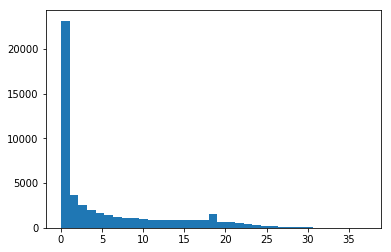

number of example that never learn: 0


In [63]:
def draw_example_distribution():
    epochs = 200
    data_stats = get_stats('./online_results', burn_in_epochs=epochs, remove_strategy='forgettable')
    
    forgetting_counting = [0] * 50000
    example_never_learn = 0
    for example_id, example_stats in data_stats.items():
        if not isinstance(example_id, str):
            presentation_acc = np.array(example_stats[1][:epochs])
            transitions = presentation_acc[1:] - presentation_acc[:-1]
            forgetting_epoch_idx = np.where(transitions == -1)[0]
            forgetting_counting[example_id] = len(forgetting_epoch_idx)
            if np.count_nonzero(presentation_acc) == 0:
                example_never_learn += 1
    plt.hist(forgetting_counting, bins=35)
    plt.show()
    print('number of example that never learn: {0}'.format(example_never_learn))

draw_example_distribution()

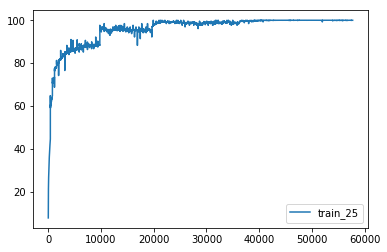

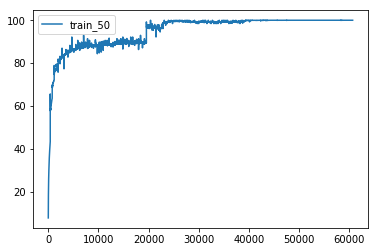

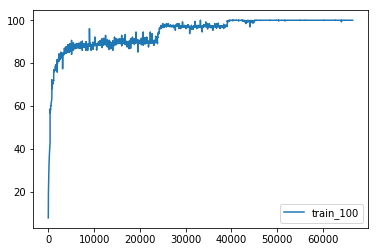

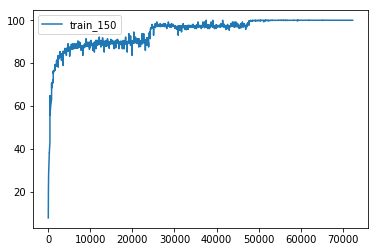

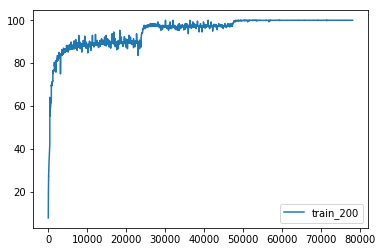

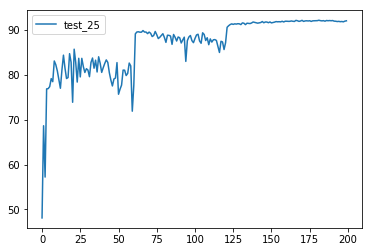

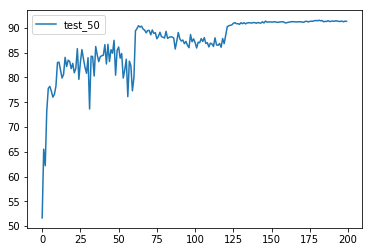

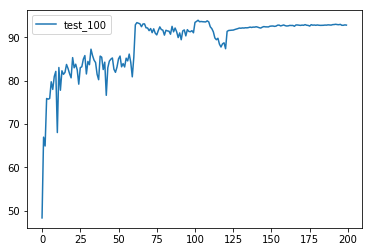

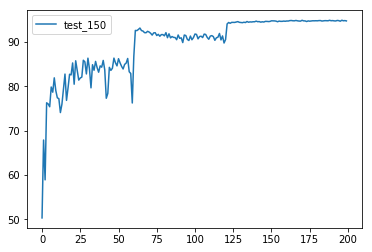

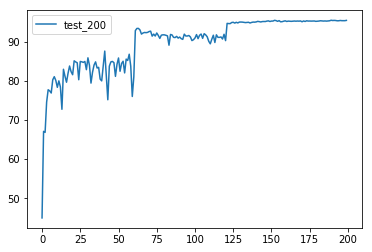

The best accuracy with burn_in_epochs=25: 92.15
The best accuracy with burn_in_epochs=50: 91.56
The best accuracy with burn_in_epochs=100: 93.91
The best accuracy with burn_in_epochs=150: 94.92
The best accuracy with burn_in_epochs=200: 95.44


In [31]:
def compare_online_different_burn_in_epochs():
    result_dir = './online_results'
    cnt = 1
    for epochs in [25, 50, 100, 150, 200]:
        data_stats = get_stats(result_dir, burn_in_epochs=epochs)
        plt.figure(cnt)
        plt.plot(data_stats['train'][1], label='train_' + str(epochs))
        cnt += 1
        plt.legend()
    for epochs in [25, 50, 100, 150, 200]:
        data_stats = get_stats(result_dir, burn_in_epochs=epochs)
        plt.figure(cnt)
        plt.plot(data_stats['test'][1], label='test_' + str(epochs))
        cnt += 1
        plt.legend()

    plt.show()
    
    for epochs in [25, 50, 100, 150, 200]:
        data_stats = get_stats(result_dir, burn_in_epochs=epochs)
        best_acc = np.max(data_stats['test'][1])
        print('The best accuracy with burn_in_epochs={0}: {1}'.format(epochs, best_acc))
    
compare_online_different_burn_in_epochs()

In [ ]:
def compare_once_different_burn_in_epochs():
    pass

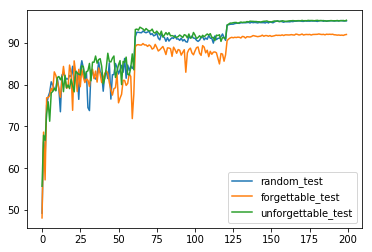

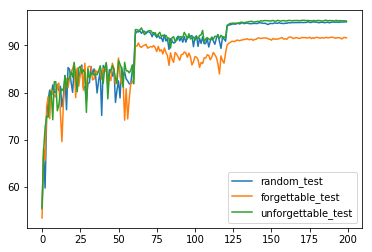

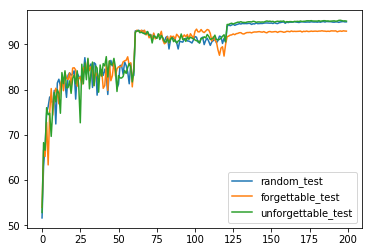

In [40]:
def compare_online_different_remove_strategy():
    # compare different remove mode: random, forgettable, unforgettable
    result_dir = './online_results'
    for cnt, epochs in enumerate([25, 50, 100]):
        random_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='random')
        forgettable_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='forgettable')
        unforgettable_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='unforgettable')
    
        plt.figure(cnt)
        plt.plot(random_stats['test'][1], label='random_test')
        plt.plot(forgettable_stats['test'][1], label='forgettable_test')
        plt.plot(unforgettable_stats['test'][1], label='unforgettable_test')
        plt.legend()
    plt.show()
    
compare_online_different_remove_strategy()

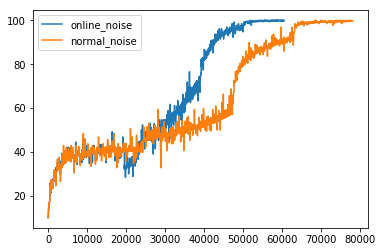

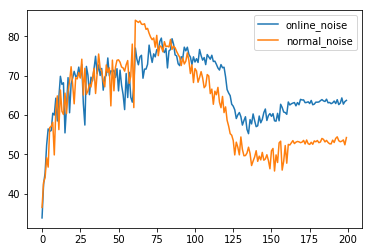

In [4]:
def train_on_noise_dataset():
    online_stats = get_stats('./online_results', burn_in_epochs=50, noise_percent_labels=50)
    random_stats = get_stats('./online_results', burn_in_epochs=50, noise_percent_labels=50, remove_strategy='random')
    normal_stats = get_stats('./online_results', burn_in_epochs=200, noise_percent_labels=50)

    plt.figure(1)
    plt.plot(online_stats['train'][1], label='online_noise')
    plt.plot(normal_stats['train'][1], label='normal_noise')
    plt.plot(random_stats['train'][1], label='random_noise')
    plt.legend()
    
    plt.figure(2)
    plt.plot(online_stats['test'][1], label='online_noise')
    plt.plot(normal_stats['test'][1], label='normal_noise')
    plt.plot(random_stats['test'][1], label='random_noise')
    plt.legend()
    plt.show()
    
train_on_noise_dataset()

In [ ]:
def compare_different_mode():
    # compare different mode: normal, pretrained, online
    normal_stats = get_data_stats()
    pass

In [ ]:
def compare_once_different_burn_in_epochs():
    fname1 = 'origin_seed_1.pkl'
    fname2 = 'remove_seed_1.pkl'
    fname3 = 'online.pkl'
    
    plt.figure(1)
    with open(fname1, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['train'][1], label='origin_train')
    with open(fname2, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['train'][1], label='remove_train')
    with open(fname3, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['train'][1], label='online_train')
    plt.legend()
    
    plt.figure(2)
    with open(fname1, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['test'][1], label='origin_test_epoch')
    with open(fname2, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['test'][1], label='remove_test_epoch')
    with open(fname3, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['test'][1], label='online_test_epoch')
    plt.legend()

    
    plt.figure(3)
    with open(fname1, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot([x * 391 for x in range(200)], data_stats['test'][1], label='origin_test_batch')
    with open(fname2, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot([x * 274 for x in range(200)], data_stats['test'][1], label='remove_test_batch')
    with open(fname3, 'rb') as fin:
        data_stats = pickle.load(fin)
        x_data = []
        counter = 0
        for i in range(200):
            if i < 50:
                counter += 391
            else:
                counter += 274
            x_data.append(counter)
        plt.plot(x_data, data_stats['test'][1], label='online_test_batch')
    plt.legend()
    plt.show()

In [ ]:
def compare_normal_and_post():
    # prepare stats
    data_dir = './online_results'
    origin_stats = get_stats(data_dir)
    post_stats = get_stats(data_dir, mode='pretrained')
        
    plt.figure(1)
    plt.plot(origin_stats['train'][1], label='origin_train')
    plt.plot(post_stats['train'][1], label='post_train')
    plt.legend()
    
    plt.figure(2)
    plt.plot(origin_stats['test'][1], label='origin_test_epoch')
    plt.plot(post_stats['test'][1], label='post_test_epoch')
    plt.legend()
    
    plt.figure(3)
    plt.plot([x * 391 for x in range(200)], origin_stats['test'][1], label='origin_test_batch')
    plt.plot([x * 277 for x in range(200)], post_stats['test'][1], label='post_test_batch')
    plt.legend()
    
    plt.show()

compare_normal_and_post()

In [ ]:
def compare_post_across_seed():
    for d, _, fs in os.walk('./cifar10_results'):
        for f in fs:
            if f.endswith('stats_dict.pkl'):
                print('including file: ' + f)

                with open(os.path.join(d, f), 'rb') as fin:
                    # dict[example_id] -> [loss, acc, margin] (list of epochs)
                    loaded = pickle.load(fin)


def compare_post_and_online():
    d = './cifar10_results'
    f = 'cifar10_sorted.pkl'

    with open(os.path.join(d, f), 'rb') as fin:
        loaded = pickle.load(fin)

    print(loaded)
    trained_indices = loaded['indices']

    with open('online.pkl', 'rb') as f:
        online_indices = pickle.load(f)

    print(trained_indices)
    print(online_indices)

    from scipy.stats import kendalltau

    # Kendall-Tau correclation
    kendalltau_result = kendalltau(trained_indices, online_indices)
    print(kendalltau_result)

    # Ranked-bias Overlap
    # quite slow
    from rbo import rbo

    rbo_result = rbo(trained_indices, online_indices, p=0.9)
    print(rbo_result)
    
    
